In [1]:
import numpy as np
import time
import torch
import random
import sys
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn, optim, autograd
from scipy.integrate import odeint

from google.colab import drive
drive.mount("/content/drive")

main_path = "/content/drive/My Drive/Workspace/Fourier_PINN/" # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)

from utils import draw_two_dimension, draw_three_dimension, MultiSubplotDraw

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
class Parameters:
    rho = 14#28.0
    sigma = 10.0
    beta = 2.667

class TrainArgs:
    iteration = 1000000
    epoch_step = 100
    test_step = 1000
    initial_lr = 0.005
    main_path = "/content/drive/My Drive/Workspace/Fourier_PINN/"


class Config:
    def __init__(self):
        self.model_name = "Lorenz_Fourier"
        self.curve_names = ["X", "Y", "Z"]
        self.params = Parameters
        self.args = TrainArgs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = 0

        self.T = 5
        self.T_unit = 1e-4
        self.T_N = int(self.T / self.T_unit)

        self.prob_dim = 3
        self.y0 = np.asarray([6.0, 6.0, 15.0])
        self.t = np.asarray([i * self.T_unit for i in range(self.T_N)])
        self.t_torch = torch.tensor(self.t, dtype=torch.float32).to(self.device)
        self.x = torch.tensor(np.asarray([[[i * self.T_unit] * self.prob_dim for i in range(self.T_N)]]), dtype=torch.float32).to(self.device)
        # print(self.x.shape)
        self.truth = odeint(self.pend, self.y0, self.t)
        print("Truth X: min={0:.6f} max={1:.6f}".format(np.min(self.truth[:,0]), np.max(self.truth[:,0])))
        print("Truth Y: min={0:.6f} max={1:.6f}".format(np.min(self.truth[:,1]), np.max(self.truth[:,1])))
        print("Truth Z: min={0:.6f} max={1:.6f}".format(np.min(self.truth[:,2]), np.max(self.truth[:,2])))

        self.modes = 64  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.width = 16
        self.fc_map_dim = 128
    
    def pend(self, y, t):
        dydt = np.asarray([
            self.params.sigma * (y[1] - y[0]),
            y[0] * (self.params.rho - y[2]) - y[1],
            y[0] * y[1] - self.params.beta * y[2]
        ])
        return dydt


In [12]:
class SpectralConv1d(nn.Module):
    def __init__(self, config):
        super(SpectralConv1d, self).__init__()
        self.config = config
        self.in_channels = self.config.width
        self.out_channels = self.config.width
        self.scale = 1 / (self.in_channels * self.out_channels)
        self.weights = nn.Parameter(self.scale * torch.rand(self.in_channels, self.out_channels, self.config.modes, dtype=torch.cfloat))

    def compl_mul1d(self, input, weights):
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft(x)
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, dtype=torch.cfloat).to(self.config.device) 
        out_ft[:, :, :self.config.modes] = self.compl_mul1d(x_ft[:, :, :self.config.modes], self.weights)
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


class FourierModel(nn.Module):
    def __init__(self, config):
        super(FourierModel, self).__init__()
        self.time_string = time.strftime("%Y%m%d_%H%M%S", time.localtime(time.time()))
        self.config = config
        self.setup_seed(self.config.seed)
        
        self.fc0 = nn.Linear(self.config.prob_dim, self.config.width)  # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.config)
        self.conv1 = SpectralConv1d(self.config)
        self.conv2 = SpectralConv1d(self.config)
        self.conv3 = SpectralConv1d(self.config)
        self.w0 = nn.Conv1d(self.config.width, self.config.width, 1)
        self.w1 = nn.Conv1d(self.config.width, self.config.width, 1)
        self.w2 = nn.Conv1d(self.config.width, self.config.width, 1)
        self.w3 = nn.Conv1d(self.config.width, self.config.width, 1)

        self.fc1 = nn.Linear(self.config.width, self.config.fc_map_dim)
        self.fc2 = nn.Linear(self.config.fc_map_dim, self.config.prob_dim)

        self.criterion = torch.nn.MSELoss().to(self.config.device)#self.criterion = torch.nn.MSELoss("sum").to(self.config.device)

        self.y_tmp = None
        self.epoch_tmp = None
        self.loss_record_tmp = None

        self.figure_save_path_folder = "{0}/figure/{1}_{2}/".format(self.config.args.main_path, self.config.model_name, self.time_string)
        if not os.path.exists(self.figure_save_path_folder):
            os.makedirs(self.figure_save_path_folder)
        self.default_colors = ["red", "blue", "green", "orange", "cyan", "purple", "pink", "indigo", "brown", "grey"]

        print("using {}".format(str(self.config.device)))
        print("iteration = {}".format(self.config.args.iteration))
        print("epoch_step = {}".format(self.config.args.epoch_step))
        print("test_step = {}".format(self.config.args.test_step))
        print("model_name = {}".format(self.config.model_name))
        print("time_string = {}".format(self.time_string))
        self.truth_loss()


    def forward(self, x):
        # print("cp1", x.shape)
        x = self.fc0(x)
        # print("cp2", x.shape)
        x = x.permute(0, 2, 1)
        # print("cp3", x.shape)

        x1 = self.conv0(x)
        # print("cp4", x1.shape)
        x2 = self.w0(x)
        # print("cp5", x2.shape)
        x = x1 + x2
        x = F.gelu(x)
        # print("cp6", x.shape)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2
        # print("cp7", x.shape)
        x = x.permute(0, 2, 1)
        # print("cp8", x.shape)
        x = self.fc1(x)
        # print("cp9", x.shape)
        x = F.gelu(x)
        # print("cp10", x.shape)

        x = self.fc2(x)
        # print("cp11", x.shape)

        # print(x.shape)
        return x

    
    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
    
    def ode_gradient(self, x, y):
        X = y[0, :, 0]
        Y = y[0, :, 1]
        Z = y[0, :, 2]
        X_t = torch.gradient(X, spacing=(self.config.t_torch,))[0]
        Y_t = torch.gradient(Y, spacing=(self.config.t_torch,))[0]
        Z_t = torch.gradient(Z, spacing=(self.config.t_torch,))[0]
        X_t_theory = self.config.params.sigma * (Y - X)
        Y_t_theory = X * (self.config.params.rho - Z) - Y
        Z_t_theory = X * Y - self.config.params.beta * Z
        """
        self.params.sigma * (y[1] - y[0]),
        y[0] * (self.params.rho - y[2]) - y[1],
        y[0] * y[1] - self.params.beta * y[2]
        """
        # print("X_t:")
        # plt.figure()
        # plt.plot(X_t.cpu().detach().numpy(), label="real")
        # plt.plot(X_t_theory.cpu().detach().numpy(), label="theory")
        # plt.legend()
        # plt.show()
        # plt.close()
        # print("Y_t:")
        # plt.figure()
        # plt.plot(Y_t.cpu().detach().numpy(), label="real")
        # plt.plot(Y_t_theory.cpu().detach().numpy(), label="theory")
        # plt.legend()
        # plt.show()
        # plt.close()
        # print("Z_t:")
        # plt.figure()
        # plt.plot(Z_t.cpu().detach().numpy(), label="real")
        # plt.plot(Z_t_theory.cpu().detach().numpy(), label="theory")
        # plt.legend()
        # plt.show()
        # plt.close()
        return X_t - X_t_theory, Y_t - Y_t_theory, Z_t - Z_t_theory

    def loss(self, y):
        y0_pred = y[0, 0, :]
        y0_true = torch.tensor(self.config.y0, dtype=torch.float32).to(self.config.device)

        ode_1, ode_2, ode_3 = self.ode_gradient(self.config.x, y)
        zeros_1D = torch.zeros([self.config.T_N]).to(self.config.device)
        zeros_nD = torch.zeros([self.config.T_N, self.config.prob_dim]).to(self.config.device)

        loss1 = 1 * self.criterion(y0_pred, y0_true)
        loss2 = 1e-3 * (self.criterion(ode_1, zeros_1D) + self.criterion(ode_2, zeros_1D) + self.criterion(ode_3, zeros_1D))
        loss3 = 1 * (self.criterion(torch.abs(y[:, :, 0] -1), y[:, :, 0] -1) + \
            self.criterion(torch.abs(y[:, :, 1] -1), y[:, :, 1] -1) + \
            self.criterion(torch.abs(y[:, :, 2]) - 1, y[:, :, 2] - 1))
        # loss4 = self.criterion(1e-3 / (y[0, :, :] ** 2 + 1e-10), zeros_nD)
        # self.criterion(1e-3 / (ode_1 ** 2 + 1e-10), zeros_1D) + self.criterion(1e-3 / (ode_2 ** 2 + 1e-10), zeros_1D) + self.criterion(1e-3 / (ode_3 ** 2 + 1e-10), zeros_1D)
        # loss5 = self.criterion(torch.abs(u_0 - v_0), u_0 - v_0)

        loss = loss1 + loss2 + loss3 
        loss_list = [loss1, loss2, loss3]
        return loss, loss_list
    
    def truth_loss(self):
        y_truth = torch.tensor(self.config.truth.reshape([1, self.config.T_N ,self.config.prob_dim])).to(self.config.device)
        tl, tl_list = self.loss(y_truth)
        loss_print_part = " ".join(["Loss_{0:d}:{1:.8f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(tl_list)])
        print("Ground truth has loss: Loss:{0:.8f} {1}".format(tl.item(), loss_print_part))
    

    def train_model(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.args.initial_lr, weight_decay=0)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda e: 1 / (e / 10000 + 1))
        self.train()

        start_time = time.time()
        start_time_0 = start_time
        loss_record = []
        
        for epoch in range(1, self.config.args.iteration + 1):
            optimizer.zero_grad()

            y = self.forward(self.config.x)
            loss, loss_list = self.loss(y)
            loss_record.append(loss.item())

            loss.backward()
            optimizer.step()
            scheduler.step()

            if epoch % self.config.args.epoch_step == 0:
                now_time = time.time()
                loss_print_part = " ".join(["Loss_{0:d}:{1:.6f}".format(i + 1, loss_part.item()) for i, loss_part in enumerate(loss_list)])
                print("Epoch [{0:05d}/{1:05d}] Loss:{2:.8f} {3} Lr:{4:.8f} Time:{5:.6f}s ({6:.2f}min in total, {7:.2f}min remains)".format(epoch, self.config.args.iteration, loss.item(), loss_print_part, optimizer.param_groups[0]["lr"], now_time - start_time, (now_time - start_time_0) / 60.0, (now_time - start_time_0) / 60.0 / epoch * (self.config.args.iteration - epoch)))
                start_time = now_time

                if epoch % self.config.args.test_step == 0:
                    self.y_tmp = y
                    self.epoch_tmp = epoch
                    self.loss_record_tmp = loss_record
                    self.test_model()
    
    def test_model(self):
        y_draw = self.y_tmp[0].cpu().detach().numpy().swapaxes(0, 1)
        x_draw = self.config.t
        y_draw_truth = self.config.truth.swapaxes(0, 1)
        save_path_2D = "{}/{}_{}_epoch={}_2D.png".format(self.figure_save_path_folder, self.config.model_name, self.time_string, self.epoch_tmp)
        save_path_3D = "{}/{}_{}_epoch={}_3D.png".format(self.figure_save_path_folder, self.config.model_name, self.time_string, self.epoch_tmp)
        draw_two_dimension(
            y_lists=np.concatenate([y_draw, y_draw_truth], axis=0),
            x_list=x_draw,
            color_list=self.default_colors[: 2 * self.config.prob_dim],
            legend_list=self.config.curve_names + ["{}_true".format(item) for item in self.config.curve_names],
            line_style_list=["solid"] * self.config.prob_dim + ["dashed"] * self.config.prob_dim,
            fig_title="{}_{}_epoch={}_2D".format(self.config.model_name, self.time_string, self.epoch_tmp),
            fig_size=(8, 6),
            show_flag=True,
            save_flag=True,
            save_path=save_path_2D,
        )
        print("2D Figure is saved to {}".format(save_path_2D))

        draw_three_dimension(
            lists=[y_draw, y_draw_truth],
            legend_list=["pred", "true"],
            color_list=self.default_colors[:2],
            line_style_list=["solid", "dashed"],
            fig_title="{}_{}_epoch={}_3D".format(self.config.model_name, self.time_string, self.epoch_tmp),
            alpha=0.7,
            show_flag=True,
            save_flag=True,
            save_path=save_path_3D,
            fig_size=(8, 6),
            line_width=1.0,
            lim_adaptive_flag=True
        )
        print("3D Figure is saved to {}".format(save_path_3D))
        self.draw_loss_multi(self.loss_record_tmp, [1.0, 0.5, 0.25])
    
    @staticmethod
    def draw_loss_multi(loss_list, last_rate_list):
        m = MultiSubplotDraw(row=1, col=len(last_rate_list), fig_size=(8 * len(last_rate_list), 6), tight_layout_flag=True, show_flag=True, save_flag=False, save_path=None)
        for one_rate in last_rate_list:
            m.add_subplot(
                y_lists=[loss_list[-int(len(loss_list) * one_rate):]],
                x_list=range(len(loss_list) - int(len(loss_list) * one_rate) + 1, len(loss_list) + 1),
                color_list=["blue"],
                line_style_list=["solid"],
                fig_title="Loss - lastest ${}$% - epoch ${}$ to ${}$".format(int(100 * one_rate), len(loss_list) - int(len(loss_list) * one_rate) + 1, len(loss_list)),
                fig_x_label="epoch",
                fig_y_label="loss",
            )
        m.draw()




 


In [21]:
config = Config()
model = FourierModel(config).to(config.device)
model.train_model()

Output hidden; open in https://colab.research.google.com to view.

using cpu
iteration = 1000000
epoch_step = 10
test_step = 100
model_name = Lorenz_Fourier
time_string = 20221015_002249
X_t:


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


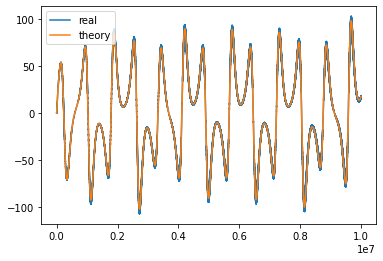

Y_t:


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


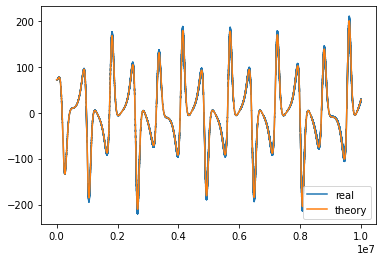

Z_t:


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


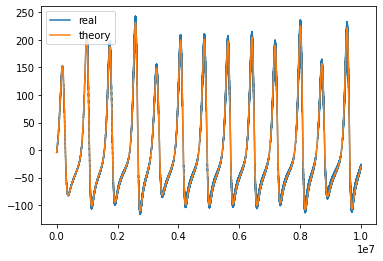

Ground truth has loss: Loss:39.232329 Loss_1:0.000000 Loss_2:39.232329 Loss_3:613.849096 Loss_4:60808494.770591


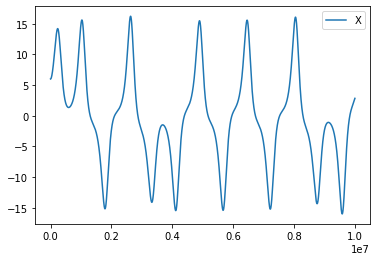

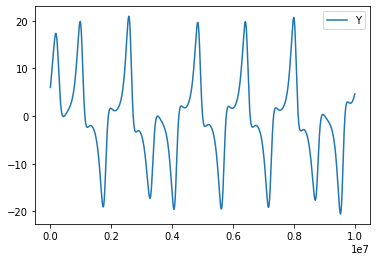

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


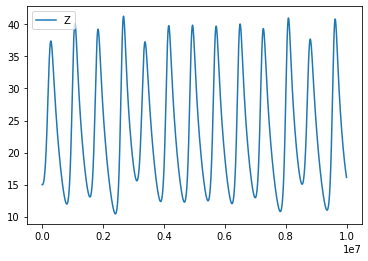

[6.0, 6.000000000359997, 6.000000001439988, 6.000000003239963, 6.000000005759915, 6.000000008999839, 6.000000012959726, 6.000000017639569, 6.000000023039359, 6.000000029159088] ... [2.8423208701368647, 2.8423387417130836, 2.842356613402035, 2.8423744852037522, 2.842392357118173, 2.8424102291453632, 2.84242810128526, 2.8424459735378975, 2.8424638459033083, 2.8424817183814306]
[6.0, 6.000071999976018, 6.000143999904072, 6.000215999784169, 6.000287999616316, 6.000359999400518, 6.000431999136783, 6.000503998825116, 6.000575998465526, 6.000647998058019] ... [4.629472961946647, 4.629502106703427, 4.629531251728201, 4.629560397021021, 4.629589542581786, 4.629618688410601, 4.629647834507363, 4.629676980872126, 4.629706127504942, 4.629735274405711]
[15.0, 14.999995995221342, 14.999991990885366, 14.999987986992078, 14.99998398354148, 14.999979980533574, 14.999975977968363, 14.99997197584585, 14.999967974166038, 14.999963972928931] ... [16.117422422023566, 16.117392595428676, 16.11736276907891, 1

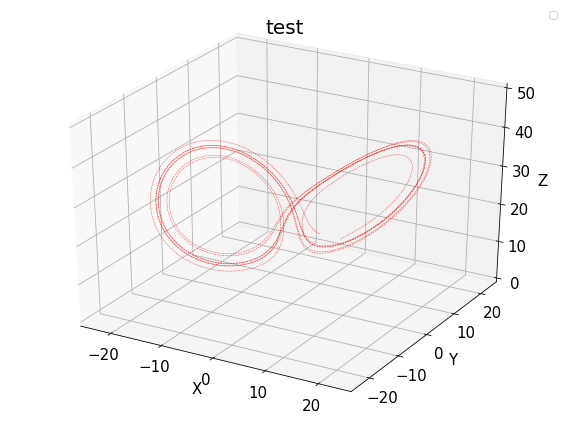

In [79]:


# config = Config()
# model = FourierModel(config).to(config.device)
# # model.train_model()
# X = model.config.truth.swapaxes(0,1)[0]
# plt.figure()
# plt.plot(X, label="X")
# plt.legend()
# plt.show()
# plt.close()

# Y = model.config.truth.swapaxes(0,1)[1]
# plt.figure()
# plt.plot(Y, label="Y")
# plt.legend()
# plt.show()
# plt.close()

# Z = model.config.truth.swapaxes(0,1)[2]
# plt.figure()
# plt.plot(Z, label="Z")
# plt.legend()
# plt.show()
# plt.close()
# print(list(X[:10]), "...", list(X[-10:]))
# print(list(Y[:10]), "...", list(Y[-10:]))
# print(list(Z[:10]), "...", list(Z[-10:]))

# draw_three_dimension(
#     lists=[model.config.truth.swapaxes(0,1)],
#     # legend_list=["true", "pred"],
#     color_list=["r", "b"],
#     line_style_list=["dashed", "solid"],
#     fig_title="test",
#     alpha=0.7,
#     # x_lim=(min(X), max(X)),
#     # y_lim=(min(Y), max(Y)),
#     # z_lim=(min(Z), max(Z)),
#     show_flag=True,
#     save_flag=False,
#     save_path=None,
#     fig_size=(8, 6),
#     line_width=0.5,
# )